In [1]:
import numpy as np
import os
import scipy.sparse as sparse

from scipy.sparse.linalg import expm_multiply
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import sqrtm


In [2]:
'''functions for axact diagonalization of the Z2 symmetric Brownian circuit'''

pauli_x = sparse.csr_matrix(np.array([[0,1],[1,0]]))
pauli_y = sparse.csr_matrix(np.array([[0,-1j],[1j,0]]))
pauli_z = sparse.csr_matrix(np.array([[1,0],[0,-1]]))
I = sparse.csr_matrix(np.eye(2))

    
def generate_op_at_site(L,site,operator):
    op = I
    for i in range(L):
        if i==site:
            current_op=operator
        else:
            current_op=I
        op = sparse.kron(op,current_op, format = "csr") if i!= 0 else current_op
    return op

'''generate Pauli matrices'''
def generate_paulis(L):
    X=[]
    Y=[]
    Z=[]
    for i in range(L): 
        X.append(generate_op_at_site(L,i,pauli_x))
        Y.append(generate_op_at_site(L,i,pauli_y))
        Z.append(generate_op_at_site(L,i,pauli_z))
    return X,Y,Z
    
'''generate Pauli matrices in the doubled HIlbert space'''

def generate_forward_backward(L):
    X,Y,Z = generate_paulis(L)
    Zf = []
    Xf = []
    Yf = []
        
    Zb = []
    Xb = []
    Yb = []

    I_single = sparse.csr_matrix(np.eye(2**L))
    for i in range(L):
        Xf.append(sparse.kron(I_single,X[i], format = "csr"))
        Yf.append(sparse.kron(I_single,Y[i], format = "csr"))
        Zf.append(sparse.kron(I_single,Z[i], format = "csr"))
        Xb.append(sparse.kron(X[i],I_single, format = "csr"))
        Yb.append(sparse.kron(Y[i],I_single, format = "csr"))
        Zb.append(sparse.kron(Z[i],I_single, format = "csr"))
    return Xf,Yf,Zf,Xb,Yb,Zb

'''TFI Hamiltonian '''
def generate_P2(L,J,p,s,X,Y,Z):
    H=0
    for i in range(L):
        H+=2*J*(sparse.csr_matrix(np.eye(2**L))-Z[i]@Z[int((i+1)%L)])+p*s/2*(sparse.csr_matrix(np.eye(2**L))-X[i])
    return H


'''2 copy Ising model aka average effective Hamiltonian of the Z2 symmetric Brownian circuit in the doubled Hilbert space'''

def generate_full_P2(L,J,U,p,s,Xf,Yf,Zf,Xb,Yb,Zb):
    P2=0
    I_double=sparse.csr_matrix(np.eye(2**(2*L)))
    for i in range(L):
        P2+= 2*J*(I_double-Zf[i]@Zb[i]@Zf[int((i+1)%L)]@Zb[int((i+1)%L)])
    for i in range(L):
        P2+=2*U*(I_double-Xf[i]@Xb[i])+p*(s-2)/4*((s+2)/(s-2)*I_double-Xf[i]@Xb[i])-p*s/4*(Xf[i]+Xb[i])
    return P2



    

## Fig. 2

In [3]:
'''compute time dependence of the Rényi-2 correlator from exact diagonalization'''
X,Y,Z = generate_paulis(4)
L=4
ps = [0,4,8,12]

T = np.linspace(0,1,100)
x_pol = 1/np.sqrt(2)**L*np.ones(2**L).transpose()

cors_diag=np.zeros((len(ps),len(T))) #Renyi-2 correlator from exact diagonalization
for i,p in enumerate(ps):
    P2=generate_P2(L,1,p,0.5,X,Y,Z)
    for j,t in enumerate(T):
        state = expm_multiply(-t*P2,x_pol)
        cors_diag[i,j]=state.transpose().conj()@Z[0]@Z[int(L/2)]@state/np.linalg.norm(state)**2

In [6]:

def load_data(p):
    path = "..\\data\\direct_simulation\\R2_and_Fidelity\\"+f"p{p}.csv"
    df = pd.read_csv(path, skiprows=[0])
    fid = df["fid"].to_numpy()
    fid_std = df["fid_std"].to_numpy()
    R2 = df["R2"].to_numpy()
    R2_std = df["R2_std"].to_numpy()
    
    return fid, fid_std, R2, R2_std 

p_values = [2,4,6,8,10,12,14,16]  
renyi_fid_sim = {p: load_data(p) for p in p_values}





In [81]:
#compute late time average to get the steady state value
avgs=[]
stds=[]
for p in p_values:
    fid, fid_std, R2, R2_std = renyi_fid_sim[p]
    avg = R2[250:].mean()
    std = R2[250:].std()
    avgs.append(avg)
    stds.append(std)

### Fig.2 (c)

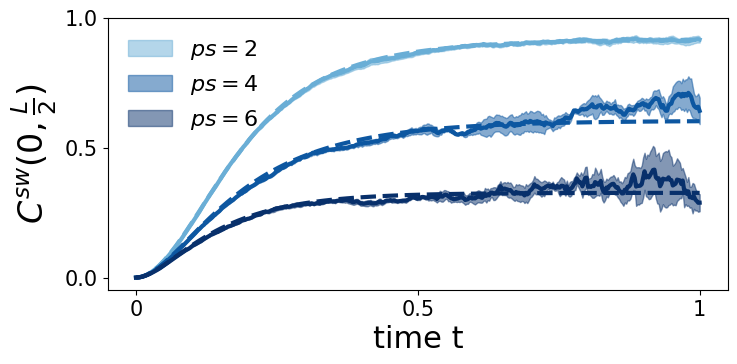

In [75]:
fig, ax=plt.subplots(1,figsize = (8,4))
t_diag = np.linspace(0,1,100)
t_sim=np.linspace(0,1,400)
colors = plt.get_cmap("Blues")(np.linspace(0.5, 1.2, 3))

fid, fid_std, R2, R2_std=renyi_fid_sim[4] 

ax.plot(t_sim,R2)
ax.plot(t_sim,np.abs(R2),color = colors[0], linewidth = 3)
ax.plot(t_diag,cors_diag[1,:], linestyle = "dashed",color = colors[0],linewidth = 3)
ax.fill_between(t_sim,np.abs(R2+R2_std),np.abs(R2-R2_std), alpha = 0.5, label = r"$ps=2$",color = colors[0])

fid, fid_std, R2, R2_std=renyi_fid_sim[8] 

ax.plot(t_sim,R2)
ax.plot(t_sim,np.abs(R2),color = colors[1], linewidth = 3)
ax.plot(t_diag,cors_diag[2,:], linestyle = "dashed",color = colors[1],linewidth = 3)
ax.fill_between(t_sim,np.abs(R2+R2_std),np.abs(R2-R2_std), alpha = 0.5, label = r"$ps=4$",color = colors[1])

fid, fid_std, R2, R2_std=renyi_fid_sim[12] 

ax.plot(t_sim,R2)
ax.plot(t_sim,np.abs(R2),color = colors[2], linewidth = 3)
ax.plot(t_diag,cors_diag[3,:], linestyle = "dashed",color = colors[2],linewidth = 3)
ax.fill_between(t_sim,np.abs(R2+R2_std),np.abs(R2-R2_std), alpha = 0.5, label = r"$ps=6$",color = colors[2])

ax.legend(fontsize = 16, frameon= False)
ax.set_yticks([0,0.5,1])
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels(["0","0.5","1"])
ax.tick_params(labelsize = 15)
ax.set_xlabel("time t", fontsize = 22)
ax.set_ylabel(r"$C^{sw}(0,\frac{L}{2})$", fontsize = 24)
plt.gcf().subplots_adjust(bottom=0.20)



### Fig.2 (d)

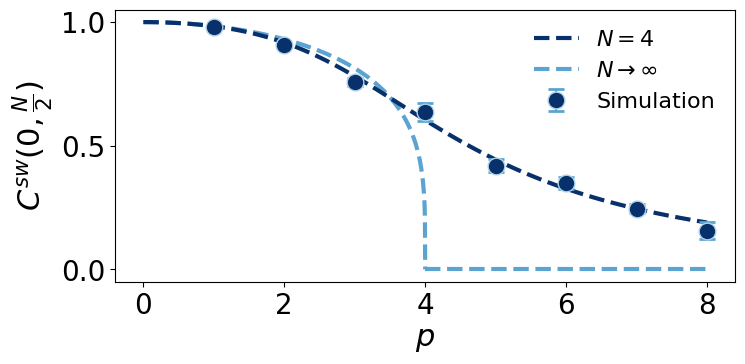

In [83]:
ps=0.5*np.array(p_values)
colors = plt.get_cmap("Blues")(np.linspace(0.1, 1.0, 5))
p_cont=np.linspace(0,8,100)
p_half=np.linspace(0,4,1000)
p_half2=np.linspace(4,8,1000)
fig, ax = plt.subplots(1,figsize = (8,4))
ax.errorbar(x=ps,y=avgs,yerr=stds,marker="o",markerfacecolor =colors[4],markeredgecolor = colors[1],markersize = 12 ,label = "Simulation",zorder = 3,solid_capstyle='projecting', capsize=6, capthick = 2,linestyle='None',color=colors[2])
ax.plot(p_cont,cors,color=colors[4], linestyle = "dashed", linewidth = 3, label = r"$N=4$",zorder = 2)
ax.plot(p_half,(1-(p_half/4)**2)**(1/4), color=colors[2],linestyle = "dashed", linewidth = 3,label =r"$N \to \infty$",zorder = 1)
ax.plot(p_half2,np.zeros(1000), color=colors[2],linestyle = "dashed", linewidth = 3,zorder = 1)
ax.set_yticks([0,0.5,1])
ax.tick_params(labelsize = 20)
ax.set_xlabel("$p$", fontsize = 22)
ax.set_ylabel(r"$C^{sw}(0,\frac{N}{2})$", fontsize = 22)
ax.legend(fontsize = 16, frameon = False)
plt.gcf().subplots_adjust(bottom=0.20)


## Fig.7 

In [ ]:
'''compute the time dependence of the Fidelity correlator'''
def get_fid_cor(U,J,s,p,L,Nt,Tmax):
    T = np.linspace(0,1.5,Nt)
    dt = Tmax/Nt
    X,Y,Z = generate_paulis(L)
    Xf,Yf,Zf,Xb,Yb,Zb=generate_forward_backward(L)
    P2_full=generate_full_P2(L,J,U,p,s,Xf,Yf,Zf,Xb,Yb,Zb)
    x_pol_double = 1/np.sqrt(2)**(2*L)*np.ones(2**(2*L)).transpose()
    fid_cor=[]
    state = x_pol_double
    density = state.copy().reshape((2**L,2**L))
    sqrtd = sqrtm(density,blocksize=2)
    fid_cor.append(np.trace(sqrtm(sqrtd@Z[0]@Z[int(L/2)]@density@Z[int(L/2)]@Z[0]@sqrtd)))
    for t in range(Nt-1):
        state = expm_multiply(-dt*P2_full,state)
        density = state.copy().reshape((2**L,2**L))
        dn = density/np.trace(density)
        dn[np.abs(dn)<0.0001]=0

        state = state/np.trace(density)
        sqrtd = sqrtm(dn,blocksize=4)
        fid_cor.append(np.trace(sqrtm(sqrtd@Z[0]@Z[int(L/2)]@dn@Z[int(L/2)]@Z[0]@sqrtd)))
    return fid_cor  



In [80]:
Nt=100
fidelities_exact={p: get_fid_cor(1,1,0.5,p,4,Nt,1) for p in p_values}


C:\Users\nzier\AppData\Local\Temp\ipykernel_33876\1552223734.py:11: DeprecationWarning: The `blocksize` argument is deprecated and will be removed in SciPy 1.18.0.
  sqrtd = sqrtm(density,blocksize=2)
C:\Users\nzier\AppData\Local\Temp\ipykernel_33876\1552223734.py:11: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  sqrtd = sqrtm(density,blocksize=2)
C:\Users\nzier\AppData\Local\Temp\ipykernel_33876\1552223734.py:12: LinAlgWarning: Matrix is ill-conditioned. The result might be inaccurate or the array might not have a square root.
  fid_cor.append(np.trace(sqrtm(sqrtd@Z[0]@Z[int(L/2)]@density@Z[int(L/2)]@Z[0]@sqrtd)))
C:\Users\nzier\AppData\Local\Temp\ipykernel_33876\1552223734.py:20: DeprecationWarning: The `blocksize` argument is deprecated and will be removed in SciPy 1.18.0.
  sqrtd = sqrtm(dn,blocksize=4)
C:\Users\nzier\AppData\Local\Temp\ipykernel_33876\1552223734.py:20: LinAlgWarning: Matrix is singular. The result mi

In [57]:
X,Y,Z = generate_paulis(4)
L=4
ps = np.linspace(0,16,100)

cors=[]
for i,p in enumerate(ps):
    P2=generate_P2(L,1,p,0.5,X,Y,Z)
    E,state= sparse.linalg.eigsh(P2,k=1, which = "SM")
    cors.append(state[:,0].transpose().conj()@Z[0]@Z[int(L/2)]@state[:,0])

### Fig.7 (a)

c:\Users\nzier\SW-SSB\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\nzier\SW-SSB\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


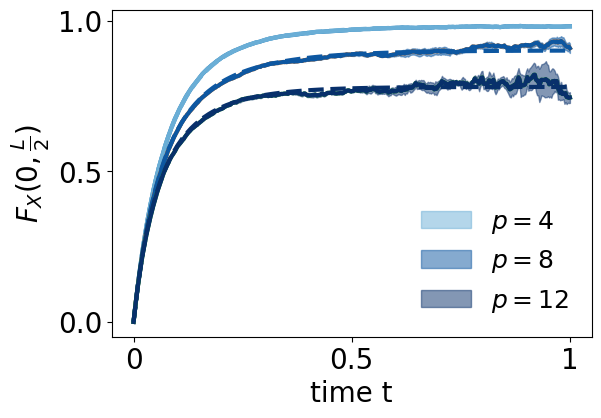

In [ ]:
fig, ax=plt.subplots(1)
t_diag = np.linspace(0,1,100)
t_sim=np.linspace(0,1,400)
colors = plt.get_cmap("Blues")(np.linspace(0.5, 1.2, 3))

fid, fid_std, R2, R2_std = data[4]
ax.plot(t_sim,fid, linewidth = 3)
ax.plot(t_sim,np.abs(fid),color = colors[0], linewidth = 3)
ax.plot(t_diag,fidelities_exact[4], linestyle = "dashed",color = colors[0], linewidth = 3)
ax.fill_between(t_sim,np.abs(fid+fid_std),np.abs(fid-fid_std), alpha = 0.5, label = r"$p=4$",color = colors[0])

fid, fid_std, R2, R2_std = data[8]
ax.plot(t_sim,fid, linewidth = 3)
ax.plot(t_sim,np.abs(fid),color = colors[1], linewidth = 3)
ax.plot(t_diag,fidelities_exact[8], linestyle = "dashed",color = colors[1], linewidth = 3)
ax.fill_between(t_sim,np.abs(fid+fid_std),np.abs(fid-fid_std), alpha = 0.5, label = r"$p=8$",color = colors[1])

fid, fid_std, R2, R2_std = data[12]
ax.plot(t_sim,fid, linewidth = 3)
ax.plot(t_sim,np.abs(fid),color = colors[2], linewidth = 3)
ax.plot(t_diag,fidelities_exact[12], linestyle = "dashed",color = colors[2], linewidth = 3)
ax.fill_between(t_sim,np.abs(fid+fid_std),np.abs(fid-fid_std), alpha = 0.5, label = r"$p=12$",color = colors[2])


ax.set_ylabel(r"Fidelity correlator", fontsize = 20)

ax.set_xlabel("time t", fontsize = 20)
ax.set_ylabel(r"$F_X(0,\frac{L}{2})$", fontsize = 20)

ax.legend(fontsize = 18 ,frameon= False)
ax.set_yticks([0,0.5,1])
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels(["0","0.5","1"])
ax.tick_params(labelsize = 20)

plt.gcf().subplots_adjust(bottom=0.20)

plt.gcf().subplots_adjust(left=0.15)


### Fig. 7 (b)

In [104]:
def load_diagonalization_data(L):
    path = os.path.join("..", "data", "correlators_Z2", f"Ising_exact_L{L}.csv")
    df = pd.read_csv(path)
    fid = df["fid"].to_numpy()
    return fid

In [109]:
Ls=[4,8,12,18]
fidelities={L: load_diagonalization_data(L) for L in Ls}

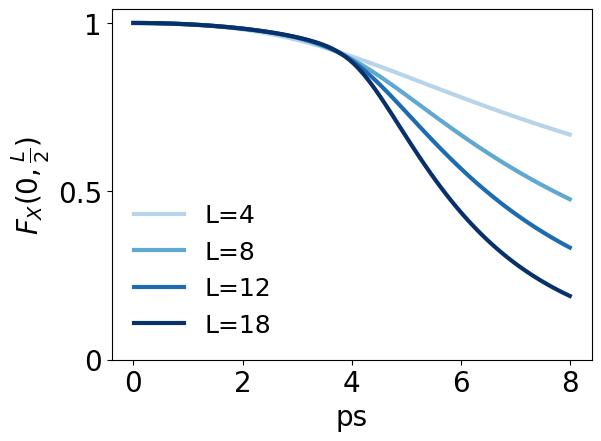

In [112]:
fig, ax = plt.subplots(1)
ps = np.linspace(0,8,len(fidelities[4]))
colors = plt.get_cmap("Blues")(np.linspace(0.3, 1, 4))
ax.plot(ps, fidelities[4], color = colors[0], label = "L=4", linewidth = 3)
ax.plot(ps, fidelities[8], color = colors[1], label = "L=8", linewidth = 3)
ax.plot(ps, fidelities[12], color = colors[2], label = "L=12", linewidth =3)
ax.plot(ps, fidelities[18], color = colors[3], label = "L=18", linewidth = 3)
ax.legend(fontsize = 18, frameon = False)
ax.set_yticks([0,0.5,1])
ax.set_xticks([0,2,4,6,8])
ax.set_yticklabels(["0","0.5","1"])
ax.tick_params(labelsize = 20)

ax.set_ylabel(r"$F_X(0,\frac{L}{2})$", fontsize = 20)

ax.set_xlabel(r"ps", fontsize = 20)

plt.gcf().subplots_adjust(left=0.15)
plt.gcf().subplots_adjust(bottom=0.15)
